In [1]:
%%capture
!pip install transformers
!pip install accelerate
# # uncomment below cell to train on TPU's
# #!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
# !pip install git+https://github.com/huggingface/accelerate
!pip install ml_collections
!pip install datasets
# !pip install pandas-profiling[notebook]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ml_collections
import datasets
import torch
import transformers
from accelerate import Accelerator, DistributedType
from datasets import load_metric, Dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data_path ="/content/drive/MyDrive/Dataset/stock.csv"

##EDA

In [38]:
df = pd.read_csv(data_path)

In [39]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [40]:
df.shape

(5842, 2)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [42]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [43]:
df.dtypes

Sentence     object
Sentiment    object
dtype: object

**Check duplicate**

In [49]:
 #Check duplicate data
 df_duplicate = df[df['Sentence'].duplicated()]
 print("No of duplicate data are: ", len(df_duplicate))
 print("duplicate datas are: ",df_duplicate)


No of duplicate data are:  520
duplicate datas are:                                                 Sentence Sentiment
266   Finnish GeoSentric 's net sales decreased to E...   neutral
283   Sales in Finland decreased by 10.5 % in Januar...  negative
349   Full-year operating result for 2008 was 3.6 mi...  negative
387   Making matters more difficult , the company sa...  negative
496   Antti Orkola , president of Kemira GrowHow 's ...  negative
...                                                 ...       ...
5827  ( ADPnews ) - Oct 21 , 2009 - Finland-based IT...  negative
5831  Finnish developer and manufacturer of mobile p...  negative
5832  Operating profit fell to EUR 38.1 mn from EUR ...  negative
5837  RISING costs have forced packaging producer Hu...  negative
5840  In the building and home improvement trade , s...   neutral

[520 rows x 2 columns]


**Check missing value**

In [50]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

**Check Dataset balanced or imbalanced**

In [51]:
df['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

**Sentence length analysis**

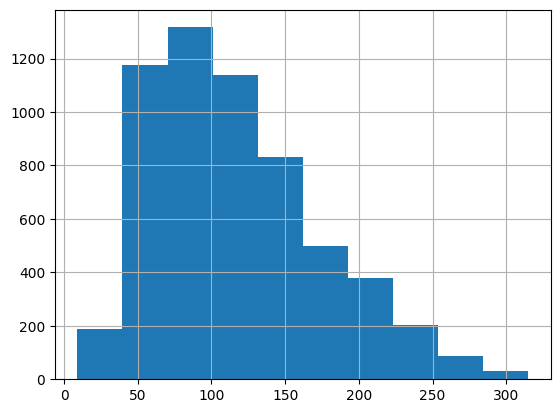

count    5842.000000
mean      117.022253
std        56.420425
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
dtype: float64

In [48]:
#Review length analysis
import seaborn as sns
import matplotlib.pyplot as plt
rev_len = [len(i) for i in df['Sentence']]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

## Preprocessing

In [7]:
def clean_text(df,field):
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've',
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat',
                      'de', 're', 'amp', 'will'])

def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(STOPWORDS)]
    text = ' '.join(text)
    return text


In [8]:
def preprocess_csv(df):
    # df=df[:50]
    print("df.shape",df.shape)

    labelencoder = LabelEncoder()
    df["label_enc"] = labelencoder.fit_transform(df["Sentiment"])
    df.rename(columns={"label": "label_desc"}, inplace=True)
    df.rename(columns={"label_enc": "labels"}, inplace=True)
    df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)

    cleaned_df = clean_text(df, "Sentence")
    cleaned_df["Sentence"] = cleaned_df["Sentence"].apply(preprocess_text)
    return cleaned_df

In [9]:
df = pd.read_csv(data_path)
df=preprocess_csv(df)

df.shape (5842, 2)


In [8]:
# Setting up the model hyperparameters

model_path= "bert_model.h5"

test_size= 0.1
validation_size=0.2
train_batch_size= 32
eval_batch_size= 32

epochs= 5
adam_epsilon= 1e-8
lr= 3e-5

max_length= 140
random_seed= 42
num_labels= 3
model_checkpoint="roberta-base"

In [10]:
df = pd.read_csv(data_path)
df=preprocess_csv(df)
# df.to_csv("/content/drive/MyDrive/Dataset/preprocessed_stock.csv",index=False)

df.shape (5842, 2)


## ML Based Approach

In [71]:
# df=pd.read_csv("/content/drive/MyDrive/Dataset/preprocessed_stock.csv")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["Sentence"]),np.array(df["Sentiment"]), test_size=0.10, random_state=42)

In [12]:
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

print(f"TF_IDF Model: Train features shape:{X_train_tf.shape} and Test features shape:{X_test_tf.shape}")

TF_IDF Model: Train features shape:(4789, 7048) and Test features shape:(533, 7048)


In [13]:
def fit_model(algo,x_train,y_train,x_test, y_test):
    algo.fit(x_train,y_train)
    y_pred = algo.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

In [14]:
accuracys = {}

In [15]:
rf = RandomForestClassifier(random_state=42)
curr_acc = fit_model(rf,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys[f"Random Forest"]=curr_acc

curr_acc:  0.7354596622889306


In [16]:
gb = GradientBoostingClassifier(random_state=42)
curr_acc = fit_model(gb,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys[f"Gradient Boosting"]=curr_acc

curr_acc:  0.7054409005628518


In [17]:
dt = DecisionTreeClassifier(random_state=42)
curr_acc = fit_model(dt,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys[f"DecisionTree"]=curr_acc

curr_acc:  0.7054409005628518


In [18]:
svc = SVC(random_state=42)
curr_acc = fit_model(svc,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys[f"SVC"]=curr_acc

curr_acc:  0.7617260787992496


In [20]:
nb = MultinomialNB()
curr_acc = fit_model(nb,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys[f"MultinomialNB"]=curr_acc

curr_acc:  0.7148217636022514


In [21]:
mlp = MLPClassifier(random_state=42)
curr_acc = fit_model(mlp,X_train_tf,y_train,X_test_tf,y_test)
print("curr_acc: ",curr_acc)
accuracys[f"MLPClassifier"]=curr_acc

curr_acc:  0.6848030018761726


In [27]:
models_df = pd.DataFrame({"Models":accuracys.keys(),"Accuracy Scores":accuracys.values()}).sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
3,SVC,0.761726
0,Random Forest,0.735460
4,MultinomialNB,0.714822
1,Gradient Boosting,0.705441
2,DecisionTree,0.705441
5,MLPClassifier,0.684803


**Using Transformer**

In [96]:
# df=pd.read_csv("/content/drive/MyDrive/Dataset/preprocessed_stock.csv")

In [10]:
training_df, test_df = train_test_split(df,test_size=test_size,random_state=random_seed,stratify=df.labels.values,)
train_df, val_df = train_test_split(training_df,test_size=validation_size,random_state=random_seed,stratify=training_df.labels.values,)
dataset = {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }
dataset = DatasetDict(dataset)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,use_fast=True)
def tokenize_function(sample):
    outputs = tokenizer(
        sample["Sentence"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    return outputs
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["Sentence","Sentiment","__index_level_0__"])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/3831 [00:00<?, ? examples/s]

Map:   0%|          | 0/958 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

In [12]:
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=train_batch_size)
eval_dataloader = DataLoader(tokenized_datasets["validation"], shuffle=False, batch_size=eval_batch_size)

In [ ]:
set_seed(random_seed)
accuracy = load_metric("accuracy")
transformers.utils.logging.set_verbosity_info()

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
optimizer = torch.optim.AdamW(params=model.parameters(), eps=adam_epsilon, lr=lr)
progress_bar = tqdm(range(epochs * len(train_dataloader)))

# Model Training
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    all_predictions = []
    all_labels = []

    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.append(predictions)
        all_labels.append(batch["labels"])

    # Concatenate all predictions and labels.
    all_predictions = torch.cat(all_predictions)[: len(tokenized_datasets["validation"])]
    all_labels = torch.cat(all_labels)[: len(tokenized_datasets["validation"])]

    eval_accuracy = accuracy.compute(predictions=all_predictions, references=all_labels)
    print(f"epoch {epoch}:", eval_accuracy)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading 

  0%|          | 0/600 [00:00<?, ?it/s]

epoch 0: {'accuracy': 0.7400835073068893}
epoch 1: {'accuracy': 0.7839248434237995}
epoch 2: {'accuracy': 0.7839248434237995}


## Conclusion

In [28]:
RoBERTa = {'Models': 'RoBERTa', 'Accuracy Scores': 0.7892}
models_df = models_df.append(RoBERTa, ignore_index = True)

In [31]:
models_df=models_df.sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
6,RoBERTa,0.789200
0,SVC,0.761726
1,Random Forest,0.735460
2,MultinomialNB,0.714822
3,Gradient Boosting,0.705441
4,DecisionTree,0.705441
5,MLPClassifier,0.684803
